# Day 1 - Lectures on Structural Econometrics for Dynamic Discrete Choice Models 

# 1 - Random utility model

Let us first review a random utility model for discrete choices in a static setting.

Consider an indidivual making a decision on whether to take a binary action, for example to buy a product. There is a state $x$ and an idiosyincratic shock $\epsilon$. Utility is additively separable in the state and the idiosyncratic shock.

- Let $U_1$ be the utility from purchasing the good which can be represented as: $$U_1(x,\epsilon) = u_1(x) + \epsilon_1 $$
- Not buying the product has a deterministic component normalized to zero: $u_0 = 0$, $U_2(x,\epsilon) = \epsilon_2$.
- The idiosyncratic utility draws are iid from a Type I Extreme Value, which in turn means that $\epsilon_1 - \epsilon_0$ follows a logistic distribution.
- Hence $P(buy) = P(U_1(x,\epsilon) > U_2(x,\epsilon)) = P(\epsilon_1 - \epsilon_0 > u_1(x) - u_0(x)) = \frac{exp(u_1(x) - u_0(x))}{1 + exp(u_1(x) - u_0(x))}$
- Furthermore the deterministic component $u_1$ can be parametrizedL $u_1(x) = \theta_0 + \theta_1 x$

If we observe $N$ individuals decisions, then $\mathbf{\theta} = (\theta_0,\theta_1)$ can be estimated by maximum likelihood. Denoting $d_n$ as the decision of individual 1, which takes value 0 when she does not purchase the product and value 1 when she does gives the likelihood contribution.
$$ \mathcal{L}_n(x_n)=\Big( \frac{\exp(u_1(x_n) - u_0(x_n)) }{1+\exp(u_1(x_n) - u_0(x_n))} \Big)^{d_n} \times \Big( \frac{1 }{1+\exp(u_1(x_n) - u_0(x_n))} \Big)^{1-d_n} $$

Then, replacing the expression for $u_1(x)$ (and the normalization for $u_0(x)$), taking the product across individuals and the log:

$$ \mathbf{\theta} = \arg \max_{\mathbf{\theta}} \sum_{i=1}^N \{d_n=1\} \times(\theta_0 + \theta_1 x_n) - \log(1+\exp(\theta_0 + \theta_1 x_n) $$


## 1-1 From static to dynamic

If we consider a case where the problem is dynamic and agents are forward-looking and conditional independence holds, the utility of choosing action $j$ can be written as the sum of current flow utility plus the expected continuation value.

$$v_1 = u_1(x,\epsilon) + \beta E[V(x'|d = 1)]$$

Then, if all $\epsilon_j$ follow a Type I Extreme Value distribution, naturally

$$P(d = 1 | x) = \frac{\exp\big(u_1(x) + \beta E[V(x') | d=1]\big)}{\sum_{j=0}^1\exp\big(u_j(x) + \beta E[V(x') | d=j]\big)}$$

The presence of the future value component in the choice probabilities substantially complicates estimation of the random utility mode, and the main goal of dynamic discrete choice estimators is to deal with this future value term.

# 2 - The Bus engine replacement model

Consider the model of bus engine replacement, as studied by Rust (1987). Mr. Zurcher maintains a fleet of buses and is in charge of maintaining it and replacing the bus engines. As the mileage in the buses increases maintenance becomes more costly. Mr. Zurcher can replace the engine, which takes the mileage of the bus to zero, but replacing the engine is costly, more so than a one period maintenance. The problem that Mr. Zurcher faces is when to change the engines.

- There are $N$ buses that are observed in $T$ months.
- In each period $t$ bus engine can be replaced $d_{1t} = 1$ or not replaced $d_{2t} = 1$. Both actions are mutually exclusive.
- Each bus has a permanent state $s$ and has a mileage $x_t$ which increases overtime when the engine is not replaced and resets to 1 when the engine is replaced. Then the state transition when the engine is replaced is denoted as $f_{1}(1|x_t) = 1$.
- The state transition when the engine is replaced follows a discretized exponential distribution, with a maximum mileage $\bar{x}$, after which no further mileage is accumulated.
$$ f_2(x_{t+1} | x_t) = \begin{cases}
\exp\big(-(x_{t+1} - x_t)\big) - \exp\big(-(x_{t+1} + \Delta_x - x_t) & \text{if } x_t < x_{t+1} < \bar{x} \\
\exp\big(-(\overline{x} - x_t)\big) & \text{if } x_{t+1}\geq\bar{x} \\
0 & \text{otherwise}
\end{cases}$$
- The (deterministic) utility of replacing the bus engine is normalized to zero. $u_1(x,s) = 0$ .
- The utility of not replacing the engine is given by $u_2(x_t,s) = \theta_1 + \theta_2 x_t + \theta_3 s$ 
- Let $z_t \equiv (x_t,s)$ denote the time-varying state variable together with the permanent bus type.
- The ex-ante value function is given by 
$$V_t(z_t) \equiv E \Big\{\sum_{\tau=t}^{\overline{T}} \sum_{j=1}^2 \beta^{\tau - t - 1} d_{jt}(z_{\tau} \epsilon_{\tau}) (u_{j}(z_{\tau}) + \epsilon_{j\tau})  \Big\}$$
- The conditional value function for choice $j$ is given by the utility flow (less the utility shock) added to the discounted value function:
$$ v_{1}(z_t) = \beta \sum_{x=1}^{\bar{X}} V(x,s) f_1(x | x_{t}) $$
$$ v_{2}(z_t) = \theta_1 + \theta_2x_t + \theta_3 s + \beta \sum_{x=1}^{\bar{X}} V(x,s) f_2(x | x_{t}) $$
- The difference between the value function $V(z_t)$ and the conditional value function $v_{j}(z_t)$ is given by the value function correction $\psi_{j}(z_t), which in the context of Type I Extreme Value distribution for the utility shock is results in:
$$ \psi_j(p(z_t)) = \gamma - log(p_j(z_t)) $$ 

With $\gamma \approx 0.577$


# 3 - Data generation

Define the discrete distribution for $x$. The lowest value is $0$, $\bar{x} = 15$ and $\Delta_x = 0.15$, which totals 301 possible values for $x$.

In [78]:
# Load the relevant packages
using StatsKit, ForwardDiff, Ipopt, NLsolve, Optim, Parameters, Zygote, LinearAlgebra, Random, Plots, BenchmarkTools, StatsBase

In [79]:
# Define the values for the x distribution
x_min=0.0;
x_max=15.0;
x_int=0.05;
x_len=Int64(1+(x_max-x_min)/x_int);
X=range(x_min,x_max,x_len);

As defined above, after replacing the engines the mileage is reset to zero $f_1(0|x_t) = 1$. $f_2(x|x_t)$ follows a discretized exponential distribution with a maximum mileage of 15.

In [80]:
# Transition matrix for mileage:
F1=zeros(x_len,x_len);
F1[:,1].=1.0;

x_tday      = repeat(X, 1, x_len); 
x_next      = x_tday';
x_zero      = zeros((x_len, x_len));

F2 = (x_next.>=x_tday) .* exp.(-(x_next - x_tday)) .* (1 .- exp(-x_int));
F2[:,end]=1 .-sum(F2[:,1:(end-1)],dims=2);
F2_cumul=cumsum(F2,dims=2);

F2

301×301 Matrix{Float64}:
 0.0487706  0.046392   0.0441294  …  1.64881e-8  1.56839e-8  3.05902e-7
 0.0        0.0487706  0.046392      1.73334e-8  1.64881e-8  3.21586e-7
 0.0        0.0        0.0487706     1.82221e-8  1.73334e-8  3.38074e-7
 0.0        0.0        0.0           1.91564e-8  1.82221e-8  3.55408e-7
 0.0        0.0        0.0           2.01386e-8  1.91564e-8  3.7363e-7
 0.0        0.0        0.0        …  2.11711e-8  2.01386e-8  3.92786e-7
 0.0        0.0        0.0           2.22566e-8  2.11711e-8  4.12925e-7
 0.0        0.0        0.0           2.33977e-8  2.22566e-8  4.34096e-7
 0.0        0.0        0.0           2.45973e-8  2.33977e-8  4.56353e-7
 0.0        0.0        0.0           2.58585e-8  2.45973e-8  4.7975e-7
 ⋮                                ⋱                          ⋮
 0.0        0.0        0.0           0.0361301   0.034368    0.67032
 0.0        0.0        0.0           0.0379826   0.0361301   0.704688
 0.0        0.0        0.0           0.03993     0.0379

In [81]:
# Rows add up to 1
sum(F2,dims=2)

301×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [82]:
# There are two permanent characteristics s, denoting bus brand.
S=[1, 2];
s_len=Int64(length(S));

In [83]:
"""
This function pefrorms value iteration, which is needed to solve the model.
"""
function value_function_iteration(x::AbstractRange{Float64},S::Vector{Int64},F1::Matrix{Float64},F2::Matrix{Float64},β::Number,θ::Vector;MaxIter=1000)
    x_len=length(x);
    γ=Base.MathConstants.eulergamma;
    value_function2=zeros(x_len,length(S));
    value_diff=1.0;
    tol=1e-5;
    iter=1;
    local v1, v2
    while (value_diff>tol) && (iter<=MaxIter)
        value_function1=value_function2;
        v1=[0.0 + β*F1[j,:]'*value_function1[:,s] for j∈eachindex(X), s∈eachindex(S)];
        v2=[θ[1]+θ[2]*X[j]+θ[3]*S[s] + β*(F2[j,:]'*value_function1[:,s]) for j=1:x_len, s∈eachindex(S)];
        value_function2=[log(exp(v1[j,s])+exp(v2[j,s]))+γ for j=1:x_len, s=1:length(S)];
        iter=iter+1;
        value_diff=maximum((value_function1 .- value_function2).^2);
    end
    ccps=[1/(1+exp(v2[j,s,]-v1[j,s])) for j=1:x_len, s=1:length(S)];
    return (ccps_true=ccps, value_function=value_function2)
end

"""
This function generates data. 
"""
function generate_data(N,T,X,S,F1,F2,F_cumul,β,θ;T_init=10,π=0.4,ex_initial=0)
    if ex_initial==1
        T_init=0;
    end
    x_data=zeros(N,T+T_init);
    x_data_index=Array{Int32}(ones(N,T+T_init));
    if ex_initial==1
        x_data_index[:,1]=rand(1:length(X),N,1);
        x_data[:,1]=X[x_data_index[:,1]];
    end
    s_data=(rand(N) .> π) .+ 1;
    d_data=zeros(N,T+T_init);

    draw_ccp=rand(N,T+T_init);
    draw_x=rand(N,T+T_init);

    (ccps,_)=value_function_iteration(X,S,F1,F2,β,θ);

    for n=1:N
        for t=1:T+T_init
            d_data[n,t]=(draw_ccp[n,t] > ccps[x_data_index[n,t],s_data[n]])+1;
            if t<T+T_init
                x_data_index[n,t+1]=1 + (d_data[n,t]==2)*sum(draw_x[n,t] .> F_cumul[x_data_index[n,t],:]); 
                x_data[n,t+1]=X[x_data_index[n,t+1]];
            end
        end
    end

    return (XData=x_data[:,T_init+1:T+T_init], SData=repeat(s_data,1,T),
        DData=d_data[:,T_init+1:T+T_init],
        XIndexData=x_data_index[:,T_init+1:T_init+T],
        TData=repeat(1:T,N,1),
        NData=repeat((1:N)',1,T)) 
end


generate_data

In [84]:
# Set the number of buses, time periods and value of parameters
N=2000;
T=15;
θ=[2.0, -0.15, 1.0];
β=0.9;
π=0.4;

Random.seed!(3000);
XData, SData, DData, XIndexData, TData, NData = generate_data(N,T,X,S,F1,F2,F2_cumul,β,θ);

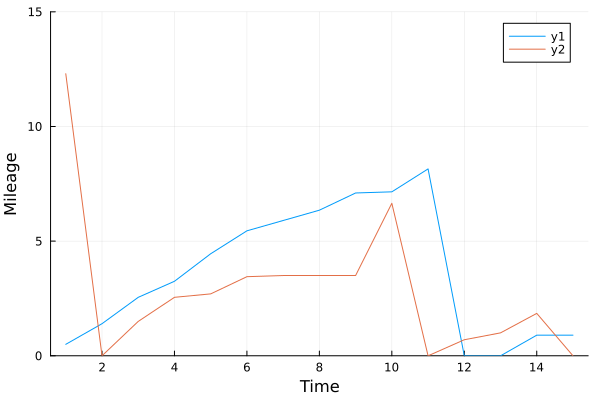

In [85]:
# Showing the mileage of one bus.
plot(XData[1:2,:]',ylabel="Mileage",xlabel="Time")
ylims!(0, 15)

In [86]:
# Showing the frequency of engine replacement in the data.
sort(countmap(sum(DData.==1,dims=2)))

OrderedCollections.OrderedDict{Int64, Int64} with 8 entries:
  0 => 2
  1 => 239
  2 => 818
  3 => 666
  4 => 229
  5 => 36
  6 => 9
  7 => 1

# 4 - CCP Estimation

### Estimating the conditional choice probability.

The first step is to estimate the conditional choice probabilities. We can obtain the maximum likehood estimates by a simple frequency estimator.

$$\hat{p}_j(x) = \frac{\sum_{n=1}^N \sum_{t=1}^T \mathbf{1}\{x_{nt}=x, \ d_{jnt} = 1\}}{\sum_{n=1}^N \sum_{t=1}^T \mathbf{1}\{x_{nt}=x\}}$$


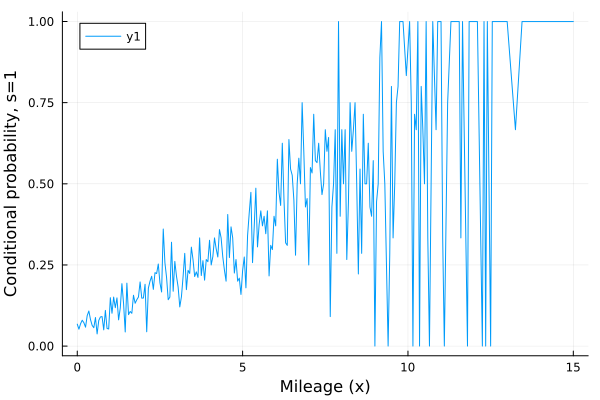

In [87]:
ccp_hat_cell = [mean(vec(DData)[(vec(XIndexData).==j) .& (vec(SData).==s)].==1) for j∈eachindex(X), s∈eachindex(S)];
epsilon=1e-4;

#ccp_hat_cell = zeros(length(X),length(S));
#
#for j in 1:length(X)
#    for s in 1:length(S)
#        ccp_hat_cell[j,s] = mean(vec(DData)[(vec(XIndexData).==j) .& (vec(SData).==s)].==1);
#    end
#end

never_reached=isnan.(ccp_hat_cell); # Keep track of states that never occur in the data
ccp_hat_cell[never_reached] .= 0.5; # Provide a value for the never reached states. 0.5 may not correspond well to what the data sugests...
ccp_hat_cell=max.(epsilon, min.(1-epsilon,ccp_hat_cell)); # Makes sure that all probabilities are in the open interval (0,1), as "1" and "0" observations cause problems.

plot(X[never_reached[:,1].==0],ccp_hat_cell[never_reached[:,1].==0,1],xlabel="Mileage (x)",ylabel="Conditional probability, s=1")


In practice, it is common to use a parametric first-stage and estimate the conditional choice probabilities with a flexible parametric or semi-parametric form. Here we use a logit with quadratic and interaction terms to estimate the conditional choice probabilities.

In [88]:
# Estimate the ccps in a flexible parametric logit
X_logit=[ones(length(XData)) vec(XData) vec(XData).^2 vec(XData).^3/10 vec(SData).==2 (vec(SData).==2).*vec(XData) (vec(SData).==2).*(vec(XData).^2)];
logit_lik(b) = -sum((vec(DData).==1).*(X_logit*b) .- log.(1 .+ exp.(X_logit*b)))
x_0= 0.1.*ones(size(X_logit,2),1);
result=optimize(logit_lik,x_0, LBFGS(),Optim.Options(g_tol = 1e-6); autodiff = :forward)
logit_params_ccp = result.minimizer;
logit_params_ccp


7×1 Matrix{Float64}:
 -2.6138763388091175
  0.49985304896255284
 -0.02578055478629067
  0.00802167631674164
 -0.8357940105234798
  0.09623546018720118
 -0.004965953816427282

In [89]:
# Fit the ccps from previous regression
xb_logit = zeros(length(X),2);

xb_logit[:,1] = logit_params_ccp[1] .+ logit_params_ccp[2]*X + logit_params_ccp[3]*(X.^2) + logit_params_ccp[4]*(X.^3)/10
xb_logit[:,2] = logit_params_ccp[5] .+ xb_logit[:,1] + logit_params_ccp[6]*X + logit_params_ccp[7]*(X.^2);

ccp_hat_logit = exp.(xb_logit)./(1 .+ exp.(xb_logit));

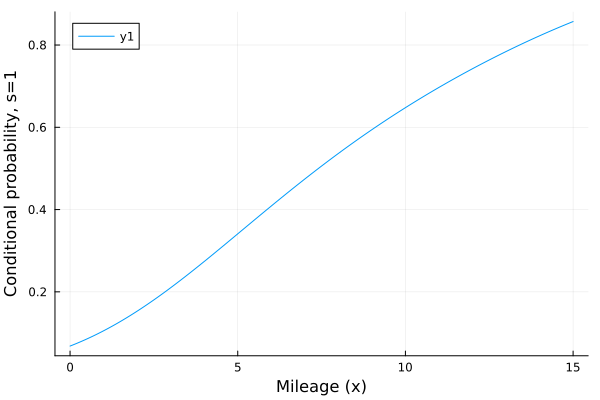

In [90]:
plot(X,ccp_hat_logit[:,1],xlabel="Mileage (x)",ylabel="Conditional probability, s=1")


# 5 - A minimum distance estimator

### Representation and identification

The mapping between the difference conditional value functions and the conditional choice probabilities $v_j(x_t) - v_k(x_t) = \psi_k(p(x_t)) -\psi_j(p(x_t))$ forms the basis for representation and identification. To generate the conditions that establish identification, we use the restrictions imposed on the utility function. In our case, we have assumed that $u_1(x) = 0$ for all states.

As presented in the slides, since the model in stationary, we can write:

$$\mathbf{u}_2 = \Psi_1 - \Psi_2 -\mathbf{u}_1 + \beta \Big(F_1 - F_2 \Big) \Big[ I - \beta F_1 \Big]^{-1}\Big(\Psi_1 + \mathbf{u}_1\Big)$$

Where $\mathbf{u}_1, \mathbf{u}_2, \Psi_1, \Psi_2 \in R^{X\cdot S}$ and

$$F_j = \left[ \begin{array}{c c c} f_j(z_1 | z_1) & \cdots & f_j(z_Z | z_1) \\ \vdots & \ddots & \vdots \\ f_j(z_1 | z_Z)  & \cdots & f_j(z_Z | z_Z) \end{array} \right]$$

Now, since everything in the right hand side can be estimated, so can $\mathbf{\hat{u}}_2$. This estimator follows the moment condition, using the unrestricted utility estimates to develop a minimum distance estimator (Altug and Miller (1998)).

$$\hat{\theta}_{MD} = \arg \min_{\theta} \Big[ \mathbf{u}_2(\mathbf{x};\theta) - \hat{\mathbf{u}}_2\Big]' W \Big[ \mathbf{u}_2(\mathbf{x};\theta) - \hat{\mathbf{u}}_2\Big]$$

First, we will implement this estimation with an identity matrix as weighting matrix.


### Estimation

In [91]:
# Get all elements to the correct dimensions

# Stack CCPs in a Vector
ccp_hat_vec = vec(ccp_hat_logit);

#In case you want to check the order of the stack, compare the second element of the vector against the two possible candidates to see how it is working
println(string("Second element of the stacked vector: ",ccp_hat_vec[2]));
println(string("Row 2, column 1: ",ccp_hat_logit[2,1]));
println(string("Row 1, column 2: ",ccp_hat_logit[1,2]));
# Easy to see, elements 1:length(X) are from column 1, elements (length(x)+1):(length(x)+length(x)) are from column 2

# F1 and F2 into square matrices of size X.S
Z_len = length(X)*length(S);
F1_all = vcat(hcat(F1,zeros(size(F1))),hcat(zeros(size(F1)),F1));
F2_all = vcat(hcat(F2,zeros(size(F2))),hcat(zeros(size(F2)),F2));


Second element of the stacked vector: 0.06985310179661547
Row 2, column 1: 0.06985310179661547
Row 1, column 2: 0.03077869176520942


The $F_1^{all}$ and $F_2^{all}$ are constructed to capture the fact that a bus cannot switch state $s$, but only $x$.

$$F_1^{all} = \left[ \begin{array}{c c} F_1 & 0 \\ 0 & F_1 \end{array} \right]$$


Since $\epsilon$ has a Type I Extreme Value distribution: 

$\psi_1(z) = \gamma - log(\hat{p}(z)) \quad$ and 

$\psi_2(z) = \gamma - log( 1 - \hat{p}(z))$

In [92]:
γ=Base.MathConstants.eulergamma;

psi1 = γ .- log.(ccp_hat_vec);
psi2 = γ .- log.(1 .- ccp_hat_vec);

u2_hat = psi1 - psi2 + β*(F1_all - F2_all)*inv(I(Z_len) - β*F1_all)*psi1;

all_data = hcat(ones(Z_len,1), repeat(X,outer=length(S)), repeat(S,inner=length(X)));

min_distance(b) = sum((all_data*b - u2_hat)'*I(Z_len)*(all_data*b - u2_hat));
x_0= 0.1.*ones(size(all_data,2),1);
result_min_dist=optimize(min_distance,x_0, LBFGS(),Optim.Options(g_tol = 1e-6); autodiff = :forward)
lambda_hat_min_dist = result_min_dist.minimizer;
print(lambda_hat_min_dist);

[2.023716669011267; -0.15468298551059936; 0.972599401406656;;]

In [93]:
# Alternatively:

lambda_hat_min_dist2 = inv(all_data'*all_data)*all_data'*u2_hat;
print(lambda_hat_min_dist2)

[2.0237166690112858, -0.15468298551059256, 0.9725994014066597]

# 6 - Estimation exploiting the renewal property

The specifics of this particular problem allow for conditional choice probability estimation to be especially beneficial. Recall that we can express the difference between the ex-ante valuation $V(x_t)$ and the conditional valuation function $v(x_t)$ as a known function of the conditional choice probabilities: $V(x_t) - v(x_t) = \psi(x_t)$. This allows the ex-ante value function to be expressed relative to a reference choice. Certain specifications for the reference choice can greatly simplify the difference in the conditional value functions that comprises the basic component of likelihood-based estimators.

In the case of Mr. Zurcher, we specify the expected value function in terms of two hypothetical choice paths from time : 
- Replace in period $t$ $\rightarrow$  Replace (again) in period $t + 1$ ,
- Not Replace in period $t$ $\rightarrow$  Replace in period $t + 1$.

The key point is that after both of these sequences, the mileage of the bus is zero at time $t+2$.

$$v_1(x) = 0 + \beta \left( \sum_{m=1}^M [v_1(x^m) - \log(p_1(x^m))]f_1(x^m | x) + \gamma\right) = \ 0 + \beta \left( \sum_{m=1}^M [u_1(x^m) - \log(p_1(x^m))]f_1(x^m | x) + \gamma\right) + \beta^2 \sum_{\tilde{m}=1}^M \sum_{m=1}^M V(x^{\tilde{m}})f_1(x^{\tilde{m}} | x^m) f_1(x^m | x)$$

$$ v_2(x) = u_2(x) + \beta \left( \sum_{m=1}^M [v_1(x^m) - \log(p_1
(x^m))]f_2(x^m | x) + \gamma\right) = \ u_2(x) + \beta \left( \sum_{m=1}^M [u_1(x^m) - \log(p_1(x^m))]f_2(x^m | x) + \gamma\right) + \beta^2 \sum_{\tilde{m}=1}^M \sum_{m=1}^M V(x^{\tilde{m}})f_1(x^{\tilde{m}} | x^m) f_2(x^m | x)$$

With a renewal choice of replacing the engine in the previous period, the last term in each of these conditional value equations is identical: $f_1(0|x_m) = 1$. This means that all terms two periods ahead or more (the terms multiplied by \beta^2) will cancel from the differenced conditional values, greatly simplifying the expression of the conditional choice probabilities. In vector form the differenced conditional value functions are expressed as:

$$\mathbf{v}_2(x) - \mathbf{v}_1(x) = \mathbf{u}_2(\mathbf{x}) - \beta \log(\mathbf{p}_1(\mathbf{x})) F_2  +  \beta\log(\mathbf{p}_1(\mathbf{x}))F_1 $$

Then, remembering that

$$p_2(x) = \frac{\exp\Big(v_2(x) - v_1(x)\Big)}{ 1 + \exp\Big(v_2(x) - v_1(x))\Big)}$$

And getting the estimates from $\hat{p}_1$ from CCPs:

$$\mathbf{v}_2(x) - \mathbf{v}_1(x) = \theta_0 + \theta_1 x + \theta_2 s - \beta \log(\mathbf{\hat{p}}_1(\mathbf{x})) F_2  +  \beta\log(\mathbf{\hat{p}}_1(\mathbf{x}))F_1 $$

$\mathbf{\theta}$ are such that maximize the likelihood function

$$\mathcal{L}(\theta ; \{x_{nt},d_{nt}\}) = \sum_{n=1}^N \sum_{t=1}^T d_{2nt} \Big(v_2(x_{nt})  - v_1(x_{nt})\Big) - \log\Big(1 + \exp(v_2^(x_{nt})  - v_1(x_{nt}) \Big)$$

In [94]:
function ccp_likelihood_renewal(theta,all_data,F1_all,F2_all,data_x_index,data_s,data_d,ccp_hat_vec)
    γ=Base.MathConstants.eulergamma;

    u2 = theta[1] .+ theta[2]*all_data[:,2] + theta[3]*all_data[:,3];
    
    diff_v = u2  + theta[4]*(F1_all*log.(ccp_hat_vec) - F2_all*log.(ccp_hat_vec))

    data_z_index = vec(XIndexData) + (vec(SData) .- 1)*length(X);
    ccp_lik = -sum((vec(data_d).==2).*(diff_v[data_z_index]) - log.(1 .+ exp.(diff_v[data_z_index])));

end


ccp_likelihood_renewal (generic function with 1 method)

In [95]:
min_renewal(theta) = ccp_likelihood_renewal(theta,all_data,F1_all,F2_all,XIndexData,SData,DData,ccp_hat_vec)
result_renewal = optimize(min_renewal,[0.1;0.1;0.1;0.1], LBFGS(),Optim.Options(g_tol = 1e-10); autodiff = :forward);
theta_renewal = result_renewal.minimizer


4-element Vector{Float64}:
  2.0401600109152245
 -0.15825926936853005
  0.9154069735002065
  0.8508886487802003

# 7 - Full information maximum likelihood

For reference, we also include a full information maximum likelihood estimation routine based on the nested fixed point. This version is simple to code but computationally very slow; however, it gives a sense of how close the CCPs estimate are to a fully efficient benchmark.

In [96]:
function fiml_likelihood(θ,DData,All_States_Index,X,S,F1,F2,β)
    _,value_function = value_function_iteration(X,S,F1,F2,β,θ)
    v1=[0.0 + β*F1[j,:]'*value_function[:,s] for j∈eachindex(X), s∈eachindex(S)];
    v2=[θ[1]+θ[2]*X[j]+θ[3]*S[s] + β*(F2[j,:]'*value_function[:,s]) for j∈eachindex(X), s∈eachindex(S)];

    return -sum((DData[j] == 2.0) * (v2[All_States_Index[j]] - v1[All_States_Index[j]] ) - log(1 + exp(v2[All_States_Index[j]]-v1[All_States_Index[j]])) for j∈eachindex(All_States_Index))

end

function fiml_estimation(DData::Matrix,XData::Matrix,SData::Matrix{Int64},X,S,F1,F2,β)
    x_len = length(X);
    All_States = [X 1.0*ones(x_len,1); X 2.0*ones(x_len,1)];
    All_States_Index=[findfirst(all(All_States .== [XData[j] SData[j]], dims=2)[:,1]) for j∈eachindex(XData)];
    f(θ) = fiml_likelihood(θ, DData,All_States_Index,X,S,F1,F2,β)
    result = optimize(f,[0.1;0.1;0.1], LBFGS(),Optim.Options(g_tol = 1e-6); autodiff = :forward);
    #result = optimize(f,[0.1;0.1;0.1]);
    return result.minimizer
end

theta_hat_fiml = fiml_estimation(DData,XData,SData,X,S,F1,F2,β);
println(theta_hat_fiml)

[2.0446656336537585, -0.14727469127307818, 0.9538124923237115]
